# Assignment 4
This assignment consists of three notebook files. Each exercise is graded using *hidden* tests. If you pass these tests then you are rewarded *full points* for that exercise; if your code fails the tests in any way then you will get *no points* for that exercise. Make sure to **read the rules** before you start the assignment.

## Rules
For this assignment the following rules apply:

**General**
 * The assignment should be completed in **groups of two or three** (enroll in a group on Brightspace).
 * Any kind of intergroup discussion will be considered fraud and both the parties will be punished.
 * All code must be written intra group. All external help, with the exception of Python/library documentation and the lecture slides, will be considered fraud (including generative AI).
 * Do not use libraries that implement the assignment for you. Ask a TA if you are unsure.

**Grading**
 * Each exercise is graded using additional hidden tests. These tests will check your solution for different (unseen) inputs.
 * If the tests pass without error (warnings are allowed) then you receive full points.
 * If a test cell takes more than five minutes to complete then this is considered an error.
 * Do not make any assumptions on the input data (such as resolution) unless specified otherwise. Doing so may result in the tests failing and thus 0 points.
 * Your grade is computed as $\frac{\text{points}}{\text{max\_points}} * 9 + 1$ and will be rounded to the closest 0.1 point.
 * Submit your code to Brightspace as a zip file containing only the notebook (`*.ipynb`) files.
 * **Do not rename the notebook files**
 
**Late Submissions**
 * Late submissions must be submitted *as soon as possible* to the "Assignment 3 - Late Submissions" assignment on Brightspace.
 * The following penalty will be applied: $\text{adjusted grade} = \text{grade} - 1 - \lceil\frac{\text{minutes late}}{10}\rceil$

<br />
 
**Before you submit**, make sure that you are not accidentaly using any global variables. Restart the kernel (wiping all global variables) and run the code from top to bottom by clicking "Kernel" => "Restart & Run all" in the menu bar at the top.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.signal
import scipy.ndimage
import os
import sys
sys.path.append("../../")
import helpers

%load_ext autoreload
%autoreload 2

## Exercise 0 (0 points)
This is a group assignment. Every student is expected to contribute to all exercises.

Enter the student IDs of all contributing students:

In [2]:
# YOUR CODE HERE
student_ids = ["1234", "5678"]

In [ ]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL

# Camera Calibration
One of the core concepts in computer graphics is going from 2D to 3D or the other way around. In the physical world cameras project the world they see through a set of lenses onto an image sensor. We can approximate this behaviour through mathematical models that describe how points in the 3D world map onto a 2D image plane.


## Pinhole Camera
The simplest and most common mathematical model is the pinhole camera: an infinitely small hole in the wall of a (shoe)box where all light rays converge. In the real-world case the sensor would be positioned behind the pinhole and the image will appear upside down. In the virtual model however we assume that the image plane is positioned in front of the camera.

![](https://www.scratchapixel.com/images/cameras/cameraobscura.png)
![](https://www.scratchapixel.com/images/cameras/pinholecam4.png)


### Perspective Projection
The pinhole model applies perspective projection to the image: far away objects appear smaller than objects that are nearby. Assume that the camera is centered at the origin and is looking along the z-axis. To achieve perspective projection we need to divide the x and y coordinates of any point by its z coordinate. We cannot achieve this with regular matrix math because it does not gives us a way to divide by z. A way we aleviate this problem is by working in the homogeneous coordinate system. Homogeneous coordinates are similar to regular coordinates except that they have an extra dimension $w$. To convert from regular to homogeneous coordinates we set the coordinate along this dimension to 1. Converting homogeneous- to regular coordinates entails dividing by the $w$ dimension (such that $w$ becomes $1$ again).
$$
\vec{v}=
\begin{pmatrix}
x \\
y \\
z \\
w=1
\end{pmatrix}
$$

By setting $w$ to the be equal to $z$ we get the effect of dividing by $z$ when converting back to regular coordinates. So the perspective transformation of our simple pinhole camera model can be described by a simple 3x4 matrix. Here $f$ determines the field-of-view of the camera:
$$
\begin{align}
\begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
&=
\begin{pmatrix}
f & 0 & 0 &0  \\
0 & f & 0 &0 \\
0 & 0 & 1 &0 
\end{pmatrix}
\begin{pmatrix}
X \\
Y \\
Z \\
w=1
\end{pmatrix} \\
&=
\begin{pmatrix}
f X \\
f Y \\
w=Z
\end{pmatrix}
=
\begin{pmatrix}
f X / Z \\
f Y / Z\\
w=1
\end{pmatrix}
\end{align}
$$

### Rotation and translation
In the previous example we assumed that the camera was centered at the origin and it was looking along the z-axis. If we want to place our camera at an arbitrary position then we need to transform the world such that it aligns with the camera.

Ignoring scaling (and skewing) such a transformation consists of a rotation and translation (movement). While rotations can be described in matrix form with regular coordinates, translations cannot. The problem we face is that we cannot describe a fixed translation (offset) as a multiplication with a point's coordinates (which vary from point to point). Again homogeneous coordinates come to the rescue by adding a known (fixed) value to the input coordinates. The following matrix describes a translation in 3D:
$$
\begin{pmatrix}
x+t_x \\
y+t_y \\
z+t_z \\
1
\end{pmatrix}
=
\begin{pmatrix}
1 & 0 & 0 & t_x \\
0 & 1 & 0 & t_y \\
0 & 0 & 1 & t_z \\
0 & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
x \\
y \\
z \\
1
\end{pmatrix}
$$

Finally, we can describe our full pinhole camera model (rotation + translation + projection) with the following equation:
$$
\begin{align}
\begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
&= 
\begin{pmatrix}
f & 0 & 0 & 0 \\
0 & f & 0 & 0\\
0 & 0 & 1 & 0
\end{pmatrix}
\begin{pmatrix}
1 & 0 & 0 & t_x \\
0 & 1 & 0 & t_y \\
0 & 0 & 1 & t_z \\
0 & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
r_{11} & r_{12} & r_{13} & 0 \\
r_{21} & r_{22} & r_{23} & 0\\
r_{31} & r_{32} & r_{33} & 0\\
0 & 0 & 0 & 1\\
\end{pmatrix}
\begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
\\
\begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
&= 
\begin{pmatrix}
f & 0 & 0 & 0 \\
0 & f & 0 & 0\\
0 & 0 & 1 & 0
\end{pmatrix}
\begin{pmatrix}
r_{11} & r_{12} & r_{13} & t_x \\
r_{21} & r_{22} & r_{23} & t_y \\
r_{31} & r_{32} & r_{33} & t_z \\
0 & 0 & 0 & 1\\
\end{pmatrix}
\begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
\\
\begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
&= 
K
[R|t]
\begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
\\
\begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
&= 
P
\begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
\end{align}
$$

In computer vision we say that the projection matrix $K$ contains the camera *intrinsics* and that the rotation/translation matrix $[R|t]$ contains the camera *extrinsics*.

### Exercise 1 (1 points)
Assuming that we know the full camera matrix $P$ which transforms 3D points into 2D screen coordinates. Implement a function that takes this matrix and an array of 3D points and transforms those points into 2D pixel coordinates.

In [3]:
XYZ = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 1], [0, 1, 0], [1, 1, 0], [1, 0, 0]])

def project_points(P, XYZ):
    projected_points = np.zeros((len(XYZ), 2))
    # TODO: Project the 3D input points XYZ onto the 2D screen using the camera matrix P.
    # YOUR CODE HERE
    
    for i in range(len(XYZ)):
        # Make homogeneous coordinate
        XYZ_h = np.append(XYZ[i], 1)
        
        # project 3d onto 2d plane
        projected_points[i] = np.dot(P, XYZ_h)[:2] / np.dot(P, XYZ_h)[2]
        # print(np.dot(P, XYZ_h)[:2] / np.dot(P, XYZ_h)[2])
    
    # print(projected_points)
    return projected_points

### Tests of exercise 1
Your method should project the points (red dots) onto the visible corners of the bottom cube that is closest to the camera.

In [ ]:
# Add your own tests here.

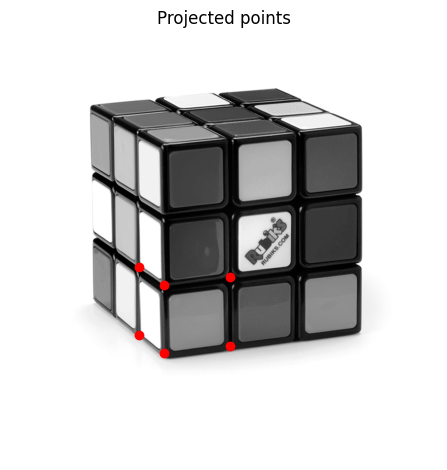

In [4]:
P = np.load(os.path.join(helpers.dataset_folder, "week4", "calibration", "rubiks_cube_matrix.npy"))
projected_corners = project_points(P, XYZ)

rubiks_cube_image = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week4", "calibration", "rubiks_cube.png"))

fig, ax = plt.subplots()
ax.axis("off")
ax.set_title("Projected points")
ax.imshow(rubiks_cube_image, cmap="gray")
ax.scatter(projected_corners[:,0], projected_corners[:,1], c="red")
fig.tight_layout()
plt.show()

In [ ]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL


### Exercise 2 (0 points)
To get feeling for how the 3D coordinate system works, you need to define the 3D coordinates of the 7 visible corners of the Rubik's cube. Add the coordinates of the points to array `XYZ`. If you implemented the previous exercise correctly then you can use the visuals to guide you.

In [6]:
def get_rubiks_corners():
    # TODO: replace these by the 3D coordinates of the visible corners of the Rubik's cube.
    # YOUR CODE HERE
    
    return np.array([[3,0,0],[0,0,0],[0,0,3],[0,3,0],[3,3,0],[0,3,3],[3,3,3]])

### Tests for exercise 2
Your array should contain the 3D coordinates of the 7 visible corners of the Rubiks cube.

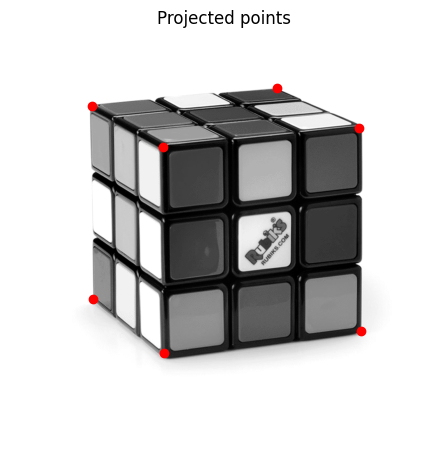

In [7]:
P = np.load(os.path.join(helpers.dataset_folder, "week4", "calibration", "rubiks_cube_matrix.npy"))
XYZ = get_rubiks_corners()
projected_corners = project_points(P, XYZ)

rubiks_cube_image = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week4", "calibration", "rubiks_cube.png"))

fig, ax = plt.subplots()
ax.axis("off")
ax.set_title("Projected points")
ax.imshow(rubiks_cube_image, cmap="gray")
ax.scatter(projected_corners[:,0], projected_corners[:,1], c="red")
fig.tight_layout()
plt.show()

In [8]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL

XYZ = get_rubiks_corners()
assert(XYZ.shape == (7, 3))

## Finding the camera matrix
We have found a couple of points in the image for which we know the 3D position. With this information you should be able to find the (3x4) camera matrix $P=K[R|t]$ that converts 3D points into 2D pixel coordinates.

### Exercise 3 (2 points)
Write a function that given the set of 3D points `XYZ` and their corresponding position in the image (2D) `xy` computes the *perspective* matrix $P$ which projects 3D points onto the image. Formulate your problem as a linear system $A\vec{x}=\vec{b}$ and solve it using `np.linalg.lstsq(A, b)[0]`.

$P$ has 3 rows and 4 columns so there are 12 unknowns in total. However, due to perspective divide, we could apply any scaling factor to the matrix and we would still get the same transformation (see lecture). We can therefor fix one of the values in the matrix to 1 such that we have to solve for 11 unknowns. This will give more accurate results and **is a requirements to get full points** (an inaccurate solutions gets half points).

In [211]:
# from numpy import shape
def compute_P(XYZ, xy):
    assert(len(XYZ) == len(xy))
    P = np.zeros((3, 4))
    # TODO: Use the mapping from XYZ to xy 
    
    n = XYZ.shape[0]

    A = np.zeros((2 * n, 11))
    b = np.zeros(2 * n)


    for i in range(n):
        X, Y, Z = XYZ[i]
        x, y = xy[i]
        
  
        A[2 * i]        = [ Y, Z, 1, 0, 0, 0, 0, -x * X, -x * Y, -x * Z, -x] 
        A[2 * i + 1]    = [ 0, 0, 0, X, Y, Z, 1, -y * X, -y * Y, -y * Z, -y]
        

        b[2 * i]        = -X
        b[2 * i + 1]    = 0





    p = np.linalg.lstsq(A, b)[0]

    # Reconstruct the projection matrix P
    P = np.zeros((3, 4))
    P[0, :] = [1] + list(p[:3])  
    P[1, :] = list(p[3:7])       
    P[2, :] = list(p[7:11]) 

    # P = P/P[0,0]
    print(P)
    return P


### Tests for exercise 3
This tests if the correctness of the computed matrix by projecting the points to screen space (using your solution to `project_points` from exercise 1). The points that were used for calibration should be projected (green) very close to their actual positions (red).

In [170]:
# Add your own tests here.

[[ 1.00000000e+00 -6.87001793e-01  3.81610299e-01 -1.36883617e+01]
 [-3.44179781e-01 -7.34121032e-02  1.10659582e+00 -1.25789733e+01]
 [ 1.07846573e-03  7.69864122e-04  7.31110497e-04 -3.90211443e-02]]


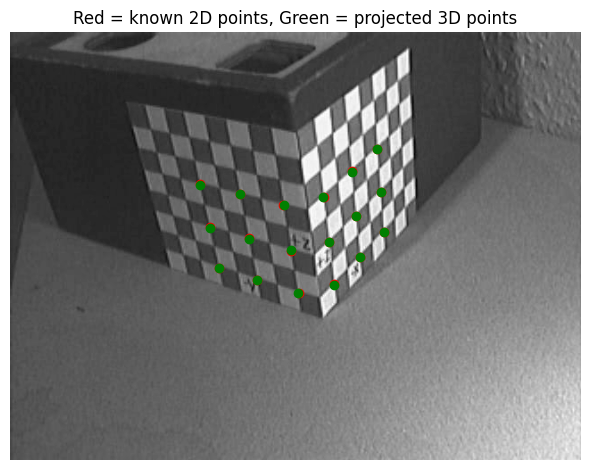

In [212]:
xy = np.array([
            [ 213.1027,  170.0499], [ 258.1908,  181.3219],
            [ 306.41  ,  193.8464], [ 351.498 ,  183.8268],
            [ 382.8092,  155.6468], [ 411.6155,  130.5978],
            [ 223.7485,  218.2691], [ 267.5841,  230.7935],
            [ 314.5509,  244.5705], [ 357.7603,  235.1771],
            [ 387.819 ,  205.1184], [ 415.3728,  178.1908],
            [ 234.3943,  263.9834], [ 276.9775,  277.1341],
            [ 323.318 ,  291.5372], [ 363.3963,  282.1438],
            [ 392.8288,  251.4589], [ 419.1301,  223.9051]])
XYZ = np.array([[0, -5, 5], [0, -3, 5], [0, -1, 5], [-1, 0, 5],
             [-3, 0, 5], [-5, 0, 5], [0, -5, 3], [0, -3, 3],
             [0, -1, 3], [-1, 0, 3], [-3, 0, 3], [-5, 0, 3],
             [0, -5, 1], [0, -3, 1], [0, -1, 1], [-1, 0, 1],
             [-3, 0, 1], [-5, 0, 1]])

# Make Python shut up about "FutureWarning: `rcond` parameter will change ..."
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    P = compute_P(XYZ, xy) # Use point pairs XYZ/xy to guess the matrix
    
# Project XYZ to the screen to confirm
projected_corners = project_points(P, XYZ)

checkerboard_cube_image = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week4", "calibration", "checkerboard_cube.jpg"))

fig, ax = plt.subplots()
ax.axis("off")
ax.set_title("Red = known 2D points, Green = projected 3D points")
ax.imshow(checkerboard_cube_image, cmap=plt.get_cmap('gray'))
ax.scatter(xy[:,0], xy[:,1], c="red")
ax.scatter(projected_corners[:,0], projected_corners[:,1], c="green")
fig.tight_layout()
plt.show()

In [ ]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL
